In [1]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
from PunctVectorizer import PunctVectorizer
from CapsVectorizer import CapsVectorizer
from collections import defaultdict
import matplotlib.pyplot as plt
import string

In [2]:
# Uncomment to Join fake and real datasets
# Load data
# Fake news is positive. Real news is 0.
# df_real = pd.read_csv("dataset/real_clean.csv")
# df_real['label'] = 0
# print(df_real.shape)

# df_fake = pd.read_csv("dataset/fake_clean.csv")
# df_fake['label'] = 1
# print(df_fake.shape)

# # Take 50/50
# df_real = df_real.sample(frac=1).reset_index(drop=True)
# df_real = df_real.loc[:df_fake.shape[0]]

# # Concat the two datasets
# df = pd.concat([df_real,df_fake])
# df = df.reset_index(drop=True)
# header = ["label","authors","date","title","text","domain"]
# df = df[header]
# print(df.shape)
# df.to_csv("dataset/data_clean.csv",index=False,encoding='utf-8')

# Load Dataset

In [29]:
df = pd.read_csv("dataset/data_clean.csv")
# data = df.sample(frac=1).reset_index(drop=True)


In [30]:
domains = set()
for index, row in data.iterrows():
    dom = row['domain']
    if 'www' not in dom:
        dom = dom[8:]
        dom = dom.split('.')[0]
    else:
        dom = dom.split('.')[1]
    
    domains.add(dom.lower())
    
domains = list(domains)
print(domains)
stop_words = text.ENGLISH_STOP_WORDS.union(domains)

['proudcons', 'usherald', 'president45donaldtrump', 'wsj', 'usa-television', 'advocate', 'unitedmediapublishing', 'fakingnews', 'uspoliticslive', 'usafirstinformation', 'redcountry', 'bighairynews', 'dailybuzzlive', 'jewsnews', 'bigamericannews', 'politicot', 'smag31', 'politicalsitenews', 'neonnettle', 'conservativedailypost', 'thenet24h', 'fprnradio', 'libertyblitzkrieg', 'newswithviews', 'dailyheadlines', 'teaparty', 'themoralofthestory', 'metropolitanworlds', 'universepolitics', 'cnn', 'empireherald', 'liberaldarkness', 'eutopia', 'usatodaynews', 'therightscoop', 'globalpoliticsnow', 'usatwentyfour', 'usadosenews', 'thefreepatriot', 'bbc', 'newsfrompolitics', 'americanoverlook', 'proamericanews', 'nutritionfacts', 'americannews', 'infostormer', 'consortiumnews', 'abriluno', 'immediatesafety', 'religionmind', 'oann', 'christianpost', 'bb4sp', 'creambmp', 'subjectpolitics', 'itmakessenseblog', 'politicono', 'tmzworldnews', 'yesimright', 'nytimes', 'thewashingtonpress', 'newsbreaksher

In [31]:
# Split the data into train and test by domain
domain_list = data.domain.values
domain_cnt = defaultdict(int)
domain_lbl = defaultdict(int)

for d in domain_list:
    domain_cnt[d] += 1
    
for index, row in data.iterrows():
    if row['label'] == 1:
        domain_lbl[row['domain']] = 1
        
# Sort into most popular fake and real domains
domain_list = np.array(list(domain_cnt.keys()))
fake_doms = defaultdict(int)
real_doms = defaultdict(int)

for d in domain_list:
    if domain_lbl[d] == 1:
        fake_doms[d] = domain_cnt[d]
    else:
        real_doms[d] = domain_cnt[d]

fake_sorted_ind = np.argsort(list(fake_doms.values()))[::-1]
real_sorted_ind = np.argsort(list(real_doms.values()))[::-1]

train_domains = []
test_domains = []

for index, val in enumerate(real_sorted_ind):
    if index % 2 == 0:
        test_domains.append(domain_list[val])
    else:
        train_domains.append(domain_list[val])
        
for index, val in enumerate(fake_sorted_ind):
    if index % 2 == 0:
        test_domains.append(domain_list[val])
    else:
        train_domains.append(domain_list[val])
        
# Take first 80% for training
# train_domains = domain_list[sorted_indices[:int(sorted_indices.shape[0]*.80)]]
# test_domains = domain_list[sorted_indices[int(sorted_indices.shape[0]*.80):]]

# df.loc[df['column_name'].isin(some_values)]
df_train = df.loc[df['domain'].isin(train_domains)]
df_test = df.loc[df['domain'].isin(test_domains)]
print(df_train.shape, df_test.shape)

(7349, 6) (4836, 6)


# Classifiers

### Punctuation classifier

In [32]:
punct_count_vect = PunctVectorizer()
X_train_counts = punct_count_vect.fit_transform(df_train['text'])
print(X_train_counts.shape)

X_test_counts = punct_count_vect.transform(df_test['text'])
print(X_test_counts.shape)

(7349, 32)
(4836, 32)


In [33]:
punct_svm_clf = LinearSVC(C=0.1).fit(X_train_counts, df_train['label'])
punct_predictions = punct_svm_clf.predict(X_test_counts)
punct_score = np.mean(punct_predictions == df_test['label'])
punct_conf = punct_svm_clf.decision_function(X_test_counts)

### Caps classifier

In [34]:
caps_count_vect = CapsVectorizer()
X_train_counts = caps_count_vect.fit_transform(df_train['text'])
print(X_train_counts.shape)

X_test_counts = caps_count_vect.transform(df_test['text'])
print(X_test_counts.shape)

['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'TOKYO', 'HORRORS']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'ABUJA']
['REUTERS', 'REUTERS', 'ANTM']
[]
['TODAY', 'TODAY', 'CHARLOTTE']
[]
['REUTERS', 'REUTERS', 'DUBAI', 'GUARANTEES']
[]
['REUTERS', 'REUTERS', 'PARIS', 'PLENTY', 'MONEY', 'HIRING', 'FIRING', 'CRTO']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'PARIS', 'PRTP', 'BABA']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'RIYADH', 'KUNA', 'KUNA']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'YORK', 'UBER']
['REUTERS', 'REUTERS', 'WASHINGTON', 'NDAA', 'NDAA', 'THAAD', 'THAAD']
['REUTERS', 'REUTERS', 'SYDNEY', 'GLEN', 'CLSA', 'TOKYO']
['FILE', 'PHOTO', 'COOL', 'REUTERS', 'FILE', 'PHOTO', 'COOL', 'REUTERS', 'ANGELES']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'AMMAN']
['FILE', 'PHOTO', 'SIBOS', 'REUTERS', 'FILE', 'PHOTO', 'SIBOS', 'REUTERS']
['TODAY', 'TODAY']
[]
['FILE', 'PHOTO', 'NYSE', 'REUTERS', 'FILE', '

[]
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'BRATISLAVA']
['REUTERS', 'REUTERS', 'LONDON']
[]
['NYSE', 'REUTERS', 'NYSE', 'REUTERS', 'YORK']
['REUTERS', 'REUTERS', 'BERLIN']
['REUTERS', 'REUTERS', 'NORRISTOWN']
['REUTERS', 'REUTERS', 'MUMBAI', 'EROS', 'TROUBLES', 'NYSE', 'NYSE']
['MUST', 'VOICES']
['REUTERS', 'REUTERS', 'MUMBAI', 'ROSN', 'OUTLET', 'PDVSA', 'TRAFG', 'EASING', 'DEBT', 'PAINS', 'ICICI', 'ICBK', 'ICICI']
['REUTERS', 'REUTERS', 'WASHINGTON']
['REUTERS', 'REUTERS', 'LISBON']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'BEIJING', 'BABA', 'AUCH']
['REUTERS', 'REUTERS', 'LONDON', 'GREAT', 'SUPPORT']
['TODAY', 'TODAY']
['REUTERS', 'REUTERS', 'AMSTERDAM', 'OPCW', 'OPCW', 'OPCW', 'OPCW', 'OPCW', 'OPCW', 'OPCW', 'OPCW']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'IAAF']
['REUTERS', 'REUTERS', 'PARIS']
[]
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'BEIJING', 'STALLING']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 

['REUTERS', 'REUTERS', 'GOTHENBURG']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'HARARE']
['AACCLA', 'REUTERS', 'AACCLA', 'REUTERS', 'PANAMA', 'CITY', 'NAFTA', 'NAFTA']
[]
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'ESPN', 'ESPN', 'FOXA']
['REUTERS', 'REUTERS', 'LONDON']
['REUTERS', 'REUTERS', 'DUBAI', 'STRIKES', 'ESCALATE']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'BEIJING', 'SHANGHAI', 'VIAB']
['TODAY', 'TODAY']
['REUTERS', 'NHCLC', 'NHCLC', 'FEMA']
['REUTERS', 'REUTERS', 'DANANG', 'APEC']
['TODAY', 'ESPN']
['REUTERS']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'BRUSSELS']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'BEIJING']
['TODAY', 'TODAY']
['REUTERS', 'REUTERS', 'HANOI']
['REUTERS', 'REUTERS', 'HARARE', 'ZANU', 'HANDS', 'DECK', 'ZANU']
['REUTERS', 'REUTERS', 'MILAN', 'BMPS']
[]
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'BERLIN', 'INSA', 'DOMESTIC', 'DEMAND', 'EUROPE', 'ENGINE']
['ATTENTION', '

[]
[]
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'WASHINGTON']
['REUTERS', 'REUTERS', 'LAGOS', 'DIAMONB']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'DUBAI', 'SAUDI', 'CRACKDOWN']
['PHOTO', 'PHOTO', 'UNESCO', 'PHOTO']
['REUTERS', 'REUTERS', 'MILAN']
['REUTERS', 'REUTERS', 'BERLIN']
[]
['REUTERS', 'REUTERS', 'LONDON', 'MILAN', 'FTSE', 'STOXX', 'STOXX', 'LLOY', 'BARC', 'FTSE', 'FTSE', 'FTSE', 'BATS', 'STOXX', 'OCDO', 'CASP', 'DLGS', 'MRVL', 'STOXX']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'RIYADH']
['REUTERS', 'REUTERS', 'MOSCOW']
['DICE']
['REUTERS', 'REUTERS', 'MWTC']
['NYPD']
['REUTERS', 'REUTERS', 'YORK']
['FILE', 'PHOTO', 'REUTERS', 'FILE', 'PHOTO', 'REUTERS', 'SYDNEY', 'BTSP', 'SEOUL', 'LONDON']
[]
[]
['REUTERS', 'REUTERS', 'BUENOS', 'AIRES']
[]
['REUTERS', 'REUTERS', 'MELBOURNE']
['IAAF', 'REUTERS', 'IAAF', 'REUTERS', 'LONDON', 'IAAF', 'IAAF', 'IAAF', 'IAAF', 'IAAF']
['ISIS', 'NATO']
['REUTERS', 'REUTERS', 'BERLIN', 'LHAG']
['REUTERS', 

['BREAKING']
['BREAKING']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['BREAKING']
['BREAKING']
['BREAKING']
['BREAKING']
['BREAKING']
['BREAKING']
[]
[]
[]
['BREAKING']
['BREAKING']
['BREAKING']
['BREAKING']
['BREAKING']
['BREAKING']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
['GETTIN', 'SOME']
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
[]
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CON

[]
[]
['EXCLUSIVE']
['BREAKING', 'NEWS']
[]
[]
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
[]
[]
[]
[]
['LIVE', 'COVERAGE', 'WATE']
[]
['DONE', 'DEAL', 'VOTES', 'WFLA']
[]
['BREAKING', 'NEWS']
[]
[]
[]
[]
[]
['EXCLUSIVE']
[]
[]
[]
['JUST']
[]
['LIVE', 'COVERAGE', 'WATE']
[]
[]
[]
[]
[]
[]
[]
[]
['BREAKING']
['BREAKING']
[]
[]
['DONE', 'DEAL', 'VOTES', 'WFLA']
['ARTIST', 'YEAR', 'ALBUM', 'YEAR', 'CONGRATULATIONS', 'WINNERS']
[]
[]
[]
[]
['KQED', 'KQED']
[]
['WFAA']
[]
[]
[]
[]
[]
[]
[]
[]
['WFAA']
[]
[]
[]
[]
['GUILTY']
['GUILTY']
[]
['TILLER']
['CNBC']
['NRDC']
[]
[]
['LGBT', 'LGBT', 'LGBT', 'LGBT', 'LGBT', 'LGBT']
['GABI', 'CNBC', 'GABI', 'CNBC', 'CNBC']
['BELLEFONTE']
['HUMBLE', 'HUNGRY', 'WORLD', 'COOLEST', 'SEXIEST', 'DUTY', 'DUTY', 'LETS', 'THIS']
[]
[]
['NYPD', 'NYPD']
['DEVELOPING', 'ISIS', 'ISIS']
[]
['LGBT', 'LGBT', 'LGBT', 'LGBT', 'LGBT', 'LGBT']
[]
['ISIS', 'ISIS', 'ISIS', 'ISIS', 'ISIS', 'ISIS', 'ISIS', 'ISIS']
['PLUS', 'WILD', 'FREE']
['HUMBLE', 'HUNG

[]
['JUST', 'WATCHED', 'MUST', 'WATCH']
[]
[]
["CNN'"]
[]
['JUST', 'WATCHED', 'MUST', 'WATCH']
[]
[]
[]
['FIFA', 'CSKA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'UEFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'FIFA', 'SAMPLE']
[]
['CRED', 'CRED', 'JUST', 'WATCHED', 'MUST', 'WATCH', 'JUST', 'WATCHED', 'MUST', 'WATCH', 'CRED']
['CLEMSON']
['SATURDAY', 'PUZZLE', 'OTTER', 'LEASE', 'UBERPOOL', 'GOTTA', 'CATCH', 'YEAH', 'DUDE', 'CHASE', 'UTLEY', 'UBERPOOL', 'GOTTA', 'CATCH', 'DATA', 'TYPE', 'CHASE', 'UTLEY']
[]
['WASHINGTON', 'COUNT', 'MICHAEL', 'FLYNN', 'FLYNN', 'FLYNN', 'FLYNN', 'FLYNN', 'FLYNN']
[]
[]
[]
[]
[]
['WASHINGTON', 'COUNT', 'MICHAEL', 'FLYNN', 'FLYNN', 'FLYNN', 'FLYNN', 'FLYNN', 'FLYNN']
[]
[]
['VIPS', 'VIPS', 'AIPAC', 'USSR']
[]
['CUNY']
[]
[]
["CNN'", 'YMCA']
[]
['MSNBC']
['FLINT', 'MICHIGAN']
[]
[]
['PTSD', 'RA

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['BREAKING']
['BREAKING']
['BREAKING']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['FOUR', 'FREE', 'TICKETS']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['MUST', 'NEVER', 'SWORN', 'DELAY', 'INAGURATION', 'INVESTIGATE', 'ARREST', 'ROSIE', 'DONALD', 'TRUMP', 'MENTALLY', 'UNSTABLE', 'LESS', 'THAN', 'WEEKS', 'STOP', 'AMERICA', 'AUTISM', 'NEVER', 'LEAVING', 'WILL', 'NEVER', 'PRESIDENT', 'MORON', 'USHERALD']
['CAIR', 'CAIR', 'CAIR', 'CAIR']
['FOIA']
['REALLY', 'MOMENTS', 'BROKE']
[]
['PLEASE', 'NOTE', 'THEFEDERALISTPAPERS']
['LOST', 'TRUMP', 'GOOD', 'BLESS', 'AMERICA', 'NEED', 'SHARES']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['POLITICO']
['POLITICO']
['POLITICO']
['MANY']
['MSNBC']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['BREAKING']
['BREAKING']
['BREAKING']
[]
[]
[]
[]
[]
[]
[]
[]

In [35]:
caps_svm_clf = LinearSVC().fit(X_train_counts, df_train['label'])
caps_predictions = caps_svm_clf.predict(X_test_counts)
caps_score = np.mean(caps_predictions == df_test['label'])
caps_conf = caps_svm_clf.decision_function(X_test_counts)

### Text classifier

In [36]:
count_vect = CountVectorizer(stop_words=stop_words,binary=True)
X_train_counts = count_vect.fit_transform(df_train['text'])
print(X_train_counts.shape)

X_test_counts = count_vect.transform(df_test['text'])
print(X_test_counts.shape)

(7349, 61882)
(4836, 61882)


In [37]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Uncomment for Bag of Words:
# X_train_tfidf = X_train_counts 
# X_test_tfidf = X_test_counts

# add punctuation features
svm_clf = LinearSVC().fit(X_train_tfidf, df_train['label'])
svm_predictions = svm_clf.predict(X_test_tfidf)
svm_score = np.mean(svm_predictions == df_test['label'])
svm_conf = svm_clf.decision_function(X_test_tfidf)

### Compare confidences and predict

In [38]:
y_test = df_test['label']

In [39]:
print("Individual Accuracies:")
print("Punct SVM:\t" + str(punct_score))
print("Caps SVM:\t" + str(caps_score))
print("TFIDF SVM:\t" + str(svm_score))

Individual Accuracies:
Punct SVM:	0.809553349876
Caps SVM:	0.616832092639
TFIDF SVM:	0.730769230769


In [40]:
svm_predictions = [0] * len(y_test)
for i in range(0, len(y_test)):
    val = (punct_score * punct_conf[i]) + (0 * caps_conf[i]) + (svm_score * svm_conf[i])
    print(val)
    if val > 0:
        svm_predictions[i] = 1

0.752025665631
-0.282247335487
-0.458297438984
1.00470287047
-0.166527492494
-3.79651150996
-1.31859553705
-11.6562033994
-2.38992824364
-2.71090447966
0.666992109673
-1.17280846722
-0.0348589123475
0.429955685313
-0.0394118613797
-1.74321155495
0.942670624021
-1.24581351433
-0.186954553985
1.08594876424
0.520904501204
-0.0942732518111
-4.47750382991
3.87400211846
-0.00598844239352
0.0693793328856
-0.959959103717
-1.94825294593
0.623216333594
-0.309686587166
-0.0772153300936
-0.00231153725911
-8.14225065181
-0.712950933441
-2.09224832902
-0.146602467897
0.180930471616
1.04599003529
0.748969240434
-0.333768218852
0.248891348515
-0.121002783953
0.244650285679
0.392019306579
4.160905453
0.180279795101
-1.28308736142
-1.60798031849
-2.02866301083
-2.7041260246
-2.06504421188
-3.78434367318
0.88541067303
-0.468520609257
-0.714537588786
6.73011630116
0.680575926817
-1.01350057411
-0.862888300962
1.65645340091
0.528206225845
-0.951380277829
0.356339606955
-0.714537588786
-11.5994569653
-0.269

-0.150160302244
0.389693794028
-4.79412320807
-3.14068286504
0.0617789098879
0.627617617638
-1.72950908949
-0.560836226736
0.107695975561
-5.97051903578
-4.5360993381
-0.14827087476
-0.389958327454
-0.362985646623
1.87951219304
-2.02949488793
-1.04892268792
-0.757940863278
-8.89493747689
0.275866388675
0.43282634782
1.17812065807
-1.90430226646
-1.38970135998
0.901920055888
-0.0967268810431
0.303860416414
-6.31707672195
-0.53210969411
-0.434919959505
-0.882713542821
0.38899384758
10.6731950545
-13.0264416047
-0.644409426539
0.550667006631
-0.66109437609
0.701553685661
-0.0215937071028
0.572240532245
-1.13767287416
-7.49737916092
0.373857166281
0.560164559747
-2.21325640662
0.0758001907943
-2.30027249113
0.27722037304
-1.05272268837
3.85163871904
-1.35553765586
-0.691662490192
0.886222377362
-2.02810807028
0.631467028903
-0.295595451135
-2.21121349465
0.776978453886
-1.16783992675
-2.77467542154
-5.67828421305
-1.73220515603
0.466618733369
0.0291958158398
-1.75702647029
-0.536452884012


1.25991875423
1.25991875423
1.25991875423
1.1936209661
1.1936209661
1.1936209661
1.61052793697
1.61052793697
1.61052793697
1.36881318954
1.36881318954
1.36881318954
1.50547399086
1.50547399086
1.50547399086
1.42428231012
1.4634507787
1.35754215603
1.36095841714
1.33771678975
1.28711920531
1.38786880756
1.48230605284
1.25347768003
1.34732241052
0.957322952917
0.677114309033
0.683001757216
0.662366999306
0.913266838989
0.777401111987
1.15543701646
0.687057380308
1.42214477884
1.04016121548
-0.0707265316457
0.31712834233
1.23270084541
0.31712834233
0.864332227315
1.39675397378
0.404123087564
0.812857502128
0.938878469793
1.53087375974
0.812857502128
1.53087375974
1.53087375974
0.864332227315
1.53087375974
0.938878469793
0.692477136448
1.32360412914
0.692477136448
1.39675397378
1.23270084541
0.404123087564
0.630857235442
-1.82960476184
0.775616765927
1.02709678164
0.180229323921
1.16835262018
0.180229323921
-1.82960476184
0.372870537139
1.02709678164
0.630857235442
0.775616765927
1.1683526

In [41]:
f1_svm_score = f1_score(y_test, svm_predictions, average='macro') 
svm_score = np.mean(svm_predictions == y_test)
print("Testing Scores")
print("SVM: \n\tf1_score: \n\taccuracy: {} ".format(f1_svm_score, svm_score))

Testing Scores
SVM: 
	f1_score: 
	accuracy: 0.7800939746397959 


## SVM Grid Search

In [116]:
### Grid Search on SVM
stop_words = text.ENGLISH_STOP_WORDS.union(domains)
clf_svm = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC())
                    ])
Cs = [0.001,.01,.1,1,10,100]
use_idf = [True,False]
parameters = {
    'tfidf__use_idf':(True,False),
    'clf__C':np.array([0.001,.01,.1,1,10,100])
}

gs_clf = GridSearchCV(clf_svm, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(df_train['text'],df_train['label'])
gs_clf_svm = gs_clf

/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


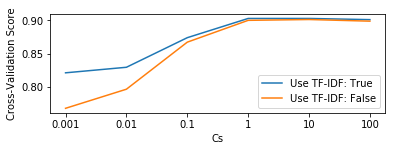

In [99]:
# Graph Results
scores = [x[1] for x in gs_clf.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(use_idf))

fig = plt.figure(1)
ax2 = fig.add_subplot(212)

a = np.arange(len(Cs))
# for ind, i in enumerate(use_idf):
ax2.plot(a, scores[:,0], label='Use TF-IDF: ' + str(use_idf[0]))
ax2.plot(a, scores[:,1], label='Use TF-IDF: ' + str(use_idf[1]))

ax2.xaxis.set_ticks(a)
ax2.xaxis.set_ticklabels(Cs)

plt.legend()
plt.xlabel('Cs')
plt.ylabel('Cross-Validation Score')
plt.show()

## MultinomialNB Grid Search

In [117]:
### Grid Search on MNB
clf = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])
alphas = [1e-3,1e-2,1e-1,0,1,10,100]
parameters = {
    'tfidf__use_idf':(True,False),    
    'clf__alpha':np.array(alphas)}
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(df_train.text,df_train.label)
gs_clf_mnb = gs_clf

/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.

/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


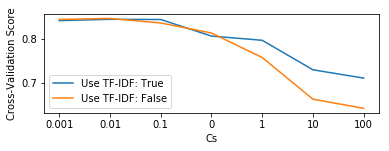

In [108]:
# Graph Results
scores = [x[1] for x in gs_clf.grid_scores_]
scores = np.array(scores).reshape(len(alphas), len(use_idf))

fig = plt.figure(1)
ax2 = fig.add_subplot(212)

a = np.arange(len(alphas))
# for ind, i in enumerate(use_idf):
ax2.plot(a, scores[:,0], label='Use TF-IDF: ' + str(use_idf[0]))
ax2.plot(a, scores[:,1], label='Use TF-IDF: ' + str(use_idf[1]))

ax2.xaxis.set_ticks(a)
ax2.xaxis.set_ticklabels(alphas)

plt.legend()
plt.xlabel('Alphas')
plt.ylabel('Cross-Validation Score')
plt.show()

## Logistic Regression Grid Search

In [118]:
### Logisitic Regression
clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])
alphas = [0.001,0.01,.1,1,10,100]
parameters = {'tfidf__use_idf':(True,False),
              'clf__C':alphas }
gs_clf = GridSearchCV(clf,parameters, n_jobs=-1)
gs_clf = gs_clf.fit(df_train.text, df_train.label)
gs_clf_log = gs_clf

/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


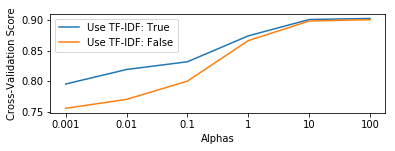

In [114]:
# Graph Results
scores = [x[1] for x in gs_clf.grid_scores_]
scores = np.array(scores).reshape(len(alphas), len(use_idf))

fig = plt.figure(1)
ax2 = fig.add_subplot(212)

a = np.arange(len(alphas))
# for ind, i in enumerate(use_idf):
ax2.plot(a, scores[:,0], label='Use TF-IDF: ' + str(use_idf[0]))
ax2.plot(a, scores[:,1], label='Use TF-IDF: ' + str(use_idf[1]))

ax2.xaxis.set_ticks(a)
ax2.xaxis.set_ticklabels(alphas)

plt.legend()
plt.xlabel('Alphas')
plt.ylabel('Cross-Validation Score')
plt.show()

In [115]:
predictions = gs_clf.predict(df_test.text)
f1 = f1_score(y_test, predictions, average='macro') 

accuracy = np.mean(predictions == df_test.label)

print("MNB: \nf1_score: {}\naccuracy: {} ".format(f1,accuracy))

MNB: 
f1_score: 0.9149243626207764
accuracy: 0.9149348362099331 


In [ ]:
joblib.dump(tfidf_transformer, 'Classifiers/tfidf_transformer.pkl')
joblib.dump(count_vect, 'Classifiers/count_vect.pkl')
joblib.dump(gs_clf_mnb, 'Classifiers/mnb_clf.pkl')
joblib.dump(gs_clf_svm, 'Classifiers/svm_clf.pkl')
joblib.dump(gs_clf_log, 'Classifiers/log_clf.pkl')

In [ ]:
# BAG with binary values
MNB:  0.861208256256
ADA:  0.88692961527
SVM:  0.923427548456
## not removing words 
MNB:  0.852378705631
ADA:  0.899721784937
SVM:  0.92836786749

# BAG with counts
MNB:  0.84710843052
ADA:  0.886742948335
SVM:  0.898489979131
## not removing them stop_words
MNB:  0.842206021811
ADA:  0.908575135645
SVM:  0.890657568726

    
# TF-IDF with counts
MNB:  0.837786994578
ADA:  0.896513330028
SVM:  0.937466064963
## not removing stop_words
MNB:  0.812818743373
ADA:  0.895799488985
SVM:  0.918595836606

# TF-IDF with binary
MNB:  0.839523809524
ADA:  0.904650376856
SVM:  0.941407136367
## not removing stop_words
MNB:  0.836683634874
ADA:  0.88884002199
SVM:  0.936449567452


# 10 Most Positive and Negative associated weights

In [130]:
theta = svm_clf.coef_
word_map = count_vect.get_feature_names()

# Find the indicies of the 5 most positive values in theta
indicies = theta[0].argsort()[-10:][::-1]
print("The 10 unigrams/bigrams with the most positive associated weights:")
for i in indicies:
    print("\t{}".format(word_map[i]))

indicies = theta[0].argsort()[:10]
print("The 10 unigrams/bigrams with the most positive associated weights:")
for i in indicies:
    print("\t{}".format(word_map[i]))

The 10 unigrams/bigrams with the most positive associated weights:
	https
	ap
	radio
	source
	loading
	декабря
	think
	pic
	rep
	donate
The 10 unigrams/bigrams with the most positive associated weights:
	reuters
	newsroom
	photo
	said
	november
	august
	credit
	caption
	2017
	story


## Classifier using Punctuation and Classification

In [60]:
# Add punctuation feature
data['text']

(1600, 42196)